
#  Doordash Data Analysis

  

## Objetivo

* Optimizar la toma de decisiones de las ordenes arrojadas por la plataforma de DoorDash a través del análisis y procesamiento de los datos proporcionados por la App.

* Brindar información valiosa derivada del análisis y procesamiento de los datos a los restaurantes frente a su competencia.


## Tabla de contenido

<div class="alert alert-block alert-info" style="margin-top: 20px">

**1. Cargando las librerias**<br>

**2. Descargando y preparando los datos**<br>

**3. Análisis exploratorio de los datos**<br>
*   Análisis del precio total generado por tienda<br>
*   Análisis de restaurantes con única orden<br>
*   Análisis del tiempo de entrega y el precio de la orden<br>

**4. Geolocalización de los restaurantes**


---



## Cargando las librerias<a id="0"></a>

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st

import matplotlib.pyplot as plt
from matplotlib import pyplot
import plotly.express as px
import plotly.io as pio
import seaborn as sns

#from datetime import timedelta
from datetime import datetime, timedelta

In [2]:
!pip3 install folium==0.9.1
import folium

print('Folium installed and imported!')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.0 MB/s eta 0:00:00
  Attempting uninstall: folium
    Found existing installation: folium 0.14.0
    Uninstalling folium-0.14.0:
      Successfully uninstalled folium-0.14.0
Folium installed and imported!


## Descargando y preparando los datos<a id="2"></a>

El dataset utilizado es arrojado por la plataforma de Doordash a cada usuario,  contiene la siguiente información:

|  Feature |  Description
|---|---|
| ORDER_CREATED_TIME  | Hora en que la orden fue creada |
| ACTUAL_PICKUP_TIME  | Hora en que la orden fue recogida |
| ACTUAL_DELIVERY_TIME  | Hora en que la orden fue entregada  |
| STORE_NAME|Nombre de la tienda|
| TOTAL_ITEM_COUNT  | Total de items de la orden |
| SUBTOTAL_IN_CENTS  | Valor en centavos de dolar  |
| SUBTOTAL_IN_DOLLARS  | Valor en dolares|
| ORDER_STATUS  | Estado final del delivery  |

<br>

Este análisis está enfocado en la ciudad de Roseville, California.

Importamos los datos provistos por Doordash dentro de un dataframe (Formato tabular).


In [3]:
path='https://docs.google.com/spreadsheets/d/e/2PACX-1vR059B2v0bukwRW8pVYnzNlVE7tkK5osG4JzrmlWMZpZobw0F2DxOojWuJLU2zr1z2w-0EpK4i0rTZ-/pub?gid=69550479&single=true&output=csv'
df = pd.read_csv(path)
df.head()

,ORDER_CREATED_TIME,ACTUAL_PICKUP_TIME,ACTUAL_DELIVERY_TIME,STORE_NAME,TOTAL_ITEM_COUNT,SUBTOTAL_IN_CENTS,SUBTOTAL_IN_DOLLARS,ORDER_STATUS
0,2021-04-04 01:33:32.079344000,2021-04-04 01:38:36.420833000,2021-04-04 01:53:14.332745000,Panda Express (1137),2,1.225.000.000.000.000,12.25,Order Delivered
1,2021-04-04 01:53:50.715216000,2021-04-04 02:02:08.242230000,2021-04-04 02:12:02.839065000,Cold Stone Creamery (20168),4,3.204.000.000.000.000,32.04,Order Delivered
2,2021-04-04 02:05:10.658239000,2021-04-04 02:39:05.110307000,2021-04-04 02:48:32.845958000,Pizza Guys #113,5,3.344.000.000.000.000,33.44,Order Delivered
3,2021-04-04 02:11:53.433320000,2021-04-04 02:39:01.865088000,2021-04-04 02:55:35.126698000,Pizza Guys #113,2,1.698.000.000.000.000,16.98,Order Delivered
4,2021-04-06 00:51:57.481510000,2021-04-06 01:08:12.985536000,2021-04-06 01:18:40.779922000,McDonald's (13464-FOOTHILL & BASELINE),10,3.803.000.000.000.000,38.03,Order Delivered


In [4]:
#Verificamos la información contenida dentro del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687 entries, 0 to 686
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ORDER_CREATED_TIME    687 non-null    object 
 1   ACTUAL_PICKUP_TIME    687 non-null    object 
 2   ACTUAL_DELIVERY_TIME  687 non-null    object 
 3   STORE_NAME            686 non-null    object 
 4   TOTAL_ITEM_COUNT      687 non-null    int64  
 5   SUBTOTAL_IN_CENTS     687 non-null    object 
 6   SUBTOTAL_IN_DOLLARS   687 non-null    float64
 7   ORDER_STATUS          687 non-null    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 43.1+ KB


Observamos que el set de datos está compuesto por 687 filas y 8 columnas la mayoria de tipo objeto (cadena de caracteres) y no contiene valores nulos.
La caracteristica mas importante que se utilizarán para analizar el set de datos es 'SUBTOTAL_IN_DOLLARS' con el fin de relacionarla con el numero de ordenes por tienda, el tiempo estimado realizando la entrega y el total en dolares generado por cada tienda.

__*Eliminamos algunas columnas del dataset:*__

*   La columna __*SUBTOTAL_IN_CENTS*__ contiene información redundante acerca del valor de cada orden en centavos, ya tenemos una columna que nos brinde esta información en dolares (SUBTOTAL_IN_DOLLARS).

*   La columna __*ORDER_STATUS*__ contiene un solo valor 'Order Delivered' que se repite en todos los registros.

In [5]:
df = df.drop(['SUBTOTAL_IN_CENTS', 'ORDER_STATUS'], axis=1)
df.head()

,ORDER_CREATED_TIME,ACTUAL_PICKUP_TIME,ACTUAL_DELIVERY_TIME,STORE_NAME,TOTAL_ITEM_COUNT,SUBTOTAL_IN_DOLLARS
0,2021-04-04 01:33:32.079344000,2021-04-04 01:38:36.420833000,2021-04-04 01:53:14.332745000,Panda Express (1137),2,12.25
1,2021-04-04 01:53:50.715216000,2021-04-04 02:02:08.242230000,2021-04-04 02:12:02.839065000,Cold Stone Creamery (20168),4,32.04
2,2021-04-04 02:05:10.658239000,2021-04-04 02:39:05.110307000,2021-04-04 02:48:32.845958000,Pizza Guys #113,5,33.44
3,2021-04-04 02:11:53.433320000,2021-04-04 02:39:01.865088000,2021-04-04 02:55:35.126698000,Pizza Guys #113,2,16.98
4,2021-04-06 00:51:57.481510000,2021-04-06 01:08:12.985536000,2021-04-06 01:18:40.779922000,McDonald's (13464-FOOTHILL & BASELINE),10,38.03


Eliminaremos el apóstrofe incluido en los nombres de algunas tiendas de la columna 'STORE_NAME' para evitar errores futuros con la manipulación de este campo


In [6]:
df['STORE_NAME'] = df['STORE_NAME'].str.replace("'",'')

Ahora, crearemos un atributo derivado llamado __*DELTA_TIME*__ el cual contendrá la diferencia entre el tiempo de entrega de la orden __*ACTUAL_DELIVERY_TIME*__ y el tiempo en que la orden fue creada __*ORDER_CREATED_TIME*__, con el fin de obtener el tiempo que se tardó cada orden en ser entregada desde el momento en el que fue aceptada.

In [7]:
#Hayamos la diferencia entre el tiempo de entrega y el tiempo de creación de la orden
df['DELTA_TIME'] = pd.to_datetime(df['ACTUAL_DELIVERY_TIME']) - pd.to_datetime(df['ORDER_CREATED_TIME'])
df['DELTA_TIME']= df['DELTA_TIME'].astype(str).str.replace("0 days","")
df.head()

,ORDER_CREATED_TIME,ACTUAL_PICKUP_TIME,ACTUAL_DELIVERY_TIME,STORE_NAME,TOTAL_ITEM_COUNT,SUBTOTAL_IN_DOLLARS,DELTA_TIME
0,2021-04-04 01:33:32.079344000,2021-04-04 01:38:36.420833000,2021-04-04 01:53:14.332745000,Panda Express (1137),2,12.25,00:19:42.253401
1,2021-04-04 01:53:50.715216000,2021-04-04 02:02:08.242230000,2021-04-04 02:12:02.839065000,Cold Stone Creamery (20168),4,32.04,00:18:12.123849
2,2021-04-04 02:05:10.658239000,2021-04-04 02:39:05.110307000,2021-04-04 02:48:32.845958000,Pizza Guys #113,5,33.44,00:43:22.187719
3,2021-04-04 02:11:53.433320000,2021-04-04 02:39:01.865088000,2021-04-04 02:55:35.126698000,Pizza Guys #113,2,16.98,00:43:41.693378
4,2021-04-06 00:51:57.481510000,2021-04-06 01:08:12.985536000,2021-04-06 01:18:40.779922000,McDonalds (13464-FOOTHILL & BASELINE),10,38.03,00:26:43.298412


Creamos otro atributo derivado llamado __*DELTA_TIME_MIN*__ el cual contiene la diferencia del tiempo de entrega y recogida de la orden en minutos y con este atributo se analizará el dataset.

In [8]:
#Separamos la columna DELTA_TIME en tres columnas: horas, minutos y segundos
df[["h","m","s"]] = df['DELTA_TIME'].str.split(":", expand=True).astype(float)

#Creamos un atributo derivado llamado DELTA_TIME_MIN el cual contiene el tiempo de cada orden en minutos
df['DELTA_TIME_MIN']=df['m']+(df['s']/100)

#Se eliminan las columnas que no nos aportan al análisis
df.drop(['h', 'm', 's'], axis=1, inplace=True)

df.head()

,ORDER_CREATED_TIME,ACTUAL_PICKUP_TIME,ACTUAL_DELIVERY_TIME,STORE_NAME,TOTAL_ITEM_COUNT,SUBTOTAL_IN_DOLLARS,DELTA_TIME,DELTA_TIME_MIN
0,2021-04-04 01:33:32.079344000,2021-04-04 01:38:36.420833000,2021-04-04 01:53:14.332745000,Panda Express (1137),2,12.25,00:19:42.253401,19.422534
1,2021-04-04 01:53:50.715216000,2021-04-04 02:02:08.242230000,2021-04-04 02:12:02.839065000,Cold Stone Creamery (20168),4,32.04,00:18:12.123849,18.121238
2,2021-04-04 02:05:10.658239000,2021-04-04 02:39:05.110307000,2021-04-04 02:48:32.845958000,Pizza Guys #113,5,33.44,00:43:22.187719,43.221877
3,2021-04-04 02:11:53.433320000,2021-04-04 02:39:01.865088000,2021-04-04 02:55:35.126698000,Pizza Guys #113,2,16.98,00:43:41.693378,43.416934
4,2021-04-06 00:51:57.481510000,2021-04-06 01:08:12.985536000,2021-04-06 01:18:40.779922000,McDonalds (13464-FOOTHILL & BASELINE),10,38.03,00:26:43.298412,26.432984


##Análisis Exploratorio de los datos


Vamos a inspeccionar la columna 'SUBTOTAL_IN_DOLLARS' con el fin de detectar aquellos pedidos a los cuales no se les haya asignado valor por haber sido realizados.

In [9]:
df.groupby(['SUBTOTAL_IN_DOLLARS'])['SUBTOTAL_IN_DOLLARS'].agg(['count'])

,count
SUBTOTAL_IN_DOLLARS,
0.00,35
1.49,1
3.18,1
4.49,1
4.87,1
...,...
80.86,1
81.65,1
84.76,1


<div class="alert alert-block alert-warning" style="margin-top: 20px">

**Resultado:** Observamos que los pedidos que no han registrado pago se muestran en nuestro dataset con un valor de 0 dolares y suman un total de 35 pedidos, para evitar eliminar estos datos vamos a reemplazarlos, reemplazaremos estos datos sin valor asignado por el valor de la mediana con el fin de evitar sesgos, ya que hay ordenes con precios muy altos lo cual influirira en el promedio si queremos reemplazarlos por este.

In [10]:
#MEDIAN
median = df['SUBTOTAL_IN_DOLLARS'].median()
df.replace(0, median, inplace = True)

Verificamos si las ordenes con valores de 0 dolares han sido reemplazadas:

In [11]:
df.groupby(['SUBTOTAL_IN_DOLLARS'])['SUBTOTAL_IN_DOLLARS'].agg(['count'])

,count
SUBTOTAL_IN_DOLLARS,
1.49,1
3.18,1
4.49,1
4.87,1
4.88,1
...,...
80.86,1
81.65,1
84.76,1


Visualizaremos las variables numéricas y la combinación entre ellas, para identificar facilmente si existen relaciones de dependencia entre algunas variables, su simetria y datos atípicos.

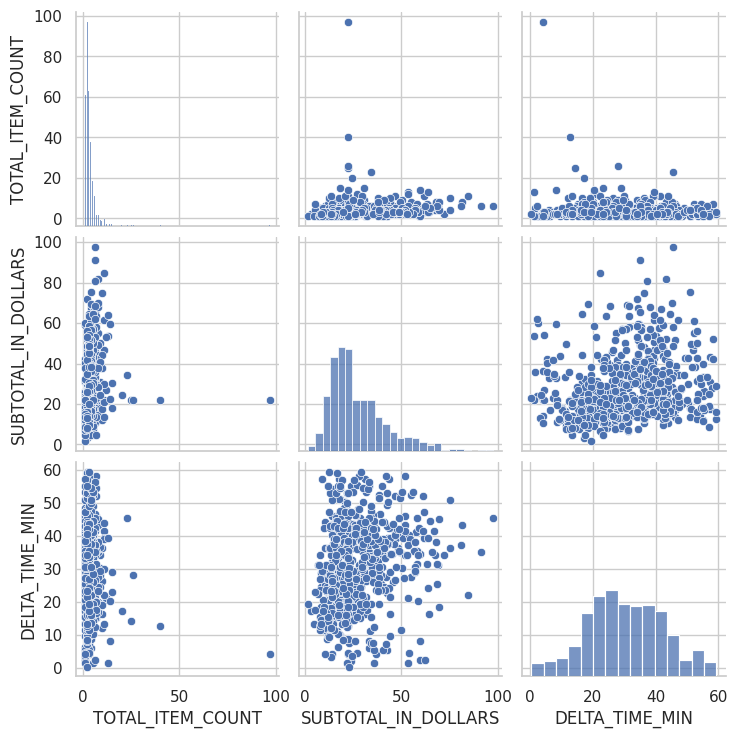

In [12]:
sub_df = df[['TOTAL_ITEM_COUNT','SUBTOTAL_IN_DOLLARS', 'DELTA_TIME_MIN']]
sns.set(style="whitegrid")
sns.pairplot(sub_df)
plt.show()

<div class="alert alert-block alert-warning" style="margin-top: 20px">

**Resultado:** Observamos varios valores atípico en el atributo del total de items

In [13]:
df.sort_values(by='TOTAL_ITEM_COUNT', ascending=False).head(2)

,ORDER_CREATED_TIME,ACTUAL_PICKUP_TIME,ACTUAL_DELIVERY_TIME,STORE_NAME,TOTAL_ITEM_COUNT,SUBTOTAL_IN_DOLLARS,DELTA_TIME,DELTA_TIME_MIN
68,2021-04-13 01:55:49.913187000,2021-04-13 02:36:44.274807000,2021-04-13 03:00:08.182434000,Walmart Grocery (Pleasant Grove Boulevard),97,22.08,01:04:18.269247,4.182692
229,2021-05-10 08:54:23.952012000,2021-05-10 17:55:44.808229000,2021-05-10 18:07:22.366014000,Walmart Grocery (Pleasant Grove Boulevard),40,22.08,09:12:58.414002,12.584140


Estas ordenes provienen de la tienda Walmart Grocery (Pleasant Grove Boulevard), se decide eliminar estos dato atípico ya que es muy poco probable recibir ordenes con un numero total de items de tal cantidad.

In [14]:
df = df.drop([68,229])

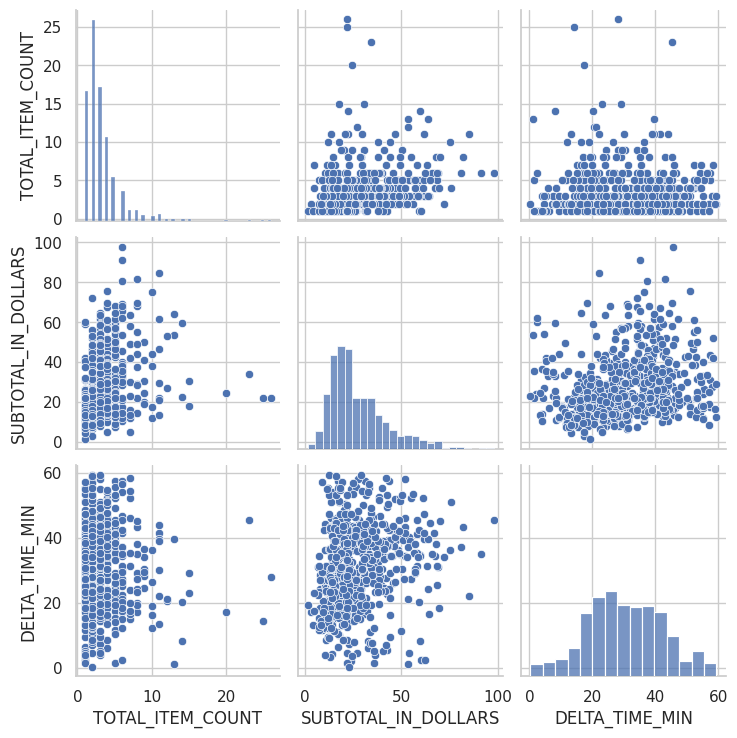

In [15]:
sub_df = df[['TOTAL_ITEM_COUNT','SUBTOTAL_IN_DOLLARS', 'DELTA_TIME_MIN']]
sns.pairplot(sub_df)
plt.show()

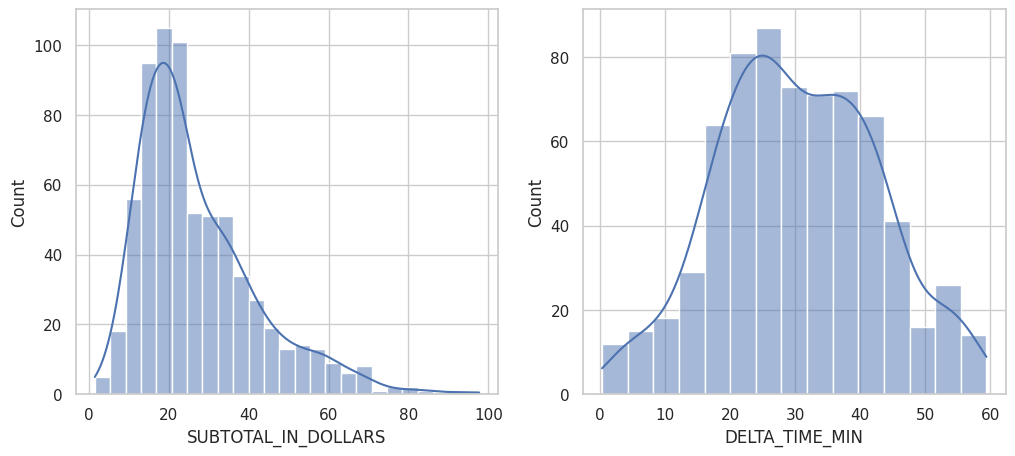

In [16]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.histplot(df["SUBTOTAL_IN_DOLLARS"], kde=True)

plt.subplot(1, 2, 2)
sns.histplot(df["DELTA_TIME_MIN"], kde=True)
plt.show()

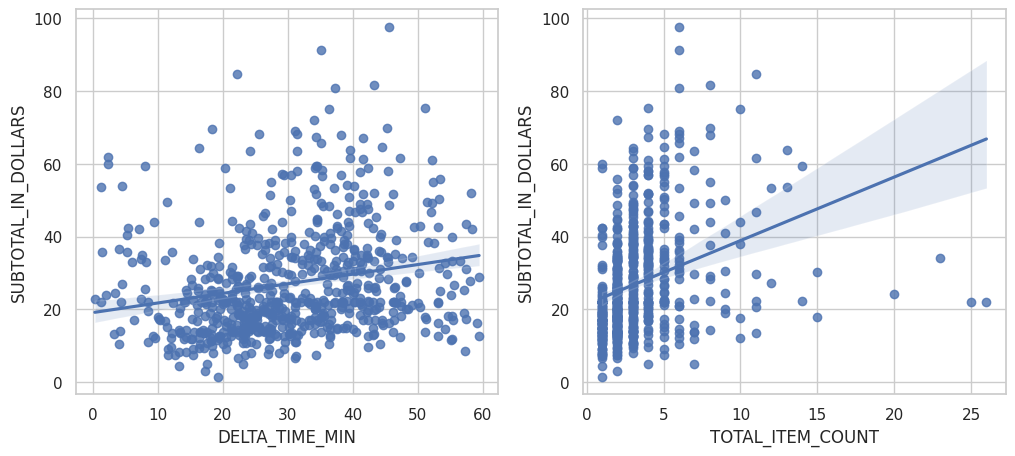

In [17]:
plt.figure(figsize=(12,5))

#subplot(nrows, ncols, index)
plt.subplot(1, 2, 1)
sns.regplot(df, x='DELTA_TIME_MIN', y='SUBTOTAL_IN_DOLLARS')

plt.subplot(1, 2, 2)
sns.regplot(df, x='TOTAL_ITEM_COUNT', y='SUBTOTAL_IN_DOLLARS')

plt.show()

<div class="alert alert-block alert-warning" style="margin-top: 20px">

**Observamos lo siguiente:**<br><br>
En cuanto a la simetria de los datos:
*   Como habiamos previsto hay sesgo positivo en el precio total por orden, reemplazar las ordenes con valor de 0 por la mediana fue una buena decisión.
*   El atributo del tiempo por orden en minutos guarda simetria.

En cuanto a la interpretación de los datos:
*   En relación con el precio la mayoria de ordenes tienen total de hasta 5 items y en raras ocasiones de hasta 10, es poco probable encontrar pedidos de mas de 10 items por orden.
*   El pago por orden mas frecuente suele estar en el rango de 10 a 35 dolares.
*   La mayoria de las ordenes son entregadas en un rango de tiempo de 20 a 45 minutos.

### Análisis del precio total generado por tienda

Ahora, agruparemos los datos por __*NOMBRE DE LA TIENDA*__, sumaremos el __*SUBTOTAL EN DOLARES*__ de cada pedido para obtener el __*PRECIO TOTAL*__ de los pedidos con respecto a cada tienda, y organizaremos el set de datos mostrando los 15 primeros restaurantes con el mayor precio total y su numero de ordenes.

In [18]:
df_sorted = df.groupby(['STORE_NAME'])['SUBTOTAL_IN_DOLLARS'].agg(['sum','count']).sort_values('sum', ascending=False).reset_index()
df_sorted.columns = ['STORE_NAME', 'TOTAL_PRICE', 'ORDERS']
df_sorted.head(15)

,STORE_NAME,TOTAL_PRICE,ORDERS
0,Jacks Urban Eats (Fountains),2306.62,64
1,Boudin SF (Roseville),715.49,23
2,Taco Bell (28763),585.95,26
3,California Pizza Kitchen (293),574.23,15
4,The Cheesecake Factory (Roseville - 0140),556.23,15
5,BJs Restaurant & Brewhouse (Roseville - 436),550.15,17
6,Burger Lounge (Roseville),422.53,15
7,Zocalo (Roseville Pkwy),365.75,11
8,"Lazy Dog Restaurant & Bar (Roseville, CA)",306.70,7
9,DashMart (SAC-2),274.42,11


Se utilizan diagramas de caja para visualizar la distribución estadística del dataset y encontrar datos atípicos.

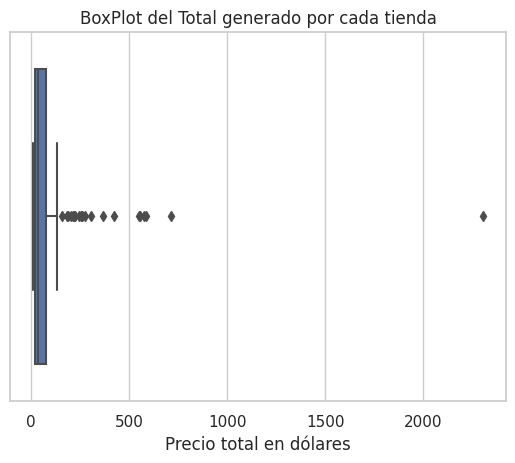

In [19]:
sns.boxplot(x = df_sorted['TOTAL_PRICE'])
plt.title("BoxPlot del Total generado por cada tienda")
plt.xlabel("Precio total en dólares")
plt.show()

<div class="alert alert-block alert-warning" style="margin-top: 20px">

**Resultado:** Se observan muchos datos atípicos debido a la variación del precio por orden, sin embargo hay uno sobresaliente el cual corresponde al Precio total en dolares generado por la tienda 'Jacks Urban Eats (Fountains)', se decide eliminar los registros de esta tienda en nuestro dataset para evitar sesgos en el análisis, sin embargo se tendrá en cuenta mas adelante.

In [20]:
#Eliminamos los registros del restaurante "Jacks Urban Eats (Fountains)"
df_sorted2 = df_sorted.drop([0])

#Inspeccionamos el nuevo dataset
df_sorted2.head(15)

,STORE_NAME,TOTAL_PRICE,ORDERS
1,Boudin SF (Roseville),715.49,23
2,Taco Bell (28763),585.95,26
3,California Pizza Kitchen (293),574.23,15
4,The Cheesecake Factory (Roseville - 0140),556.23,15
5,BJs Restaurant & Brewhouse (Roseville - 436),550.15,17
6,Burger Lounge (Roseville),422.53,15
7,Zocalo (Roseville Pkwy),365.75,11
8,"Lazy Dog Restaurant & Bar (Roseville, CA)",306.70,7
9,DashMart (SAC-2),274.42,11
10,Mendocino Farms (Roseville Pkwy),260.01,10


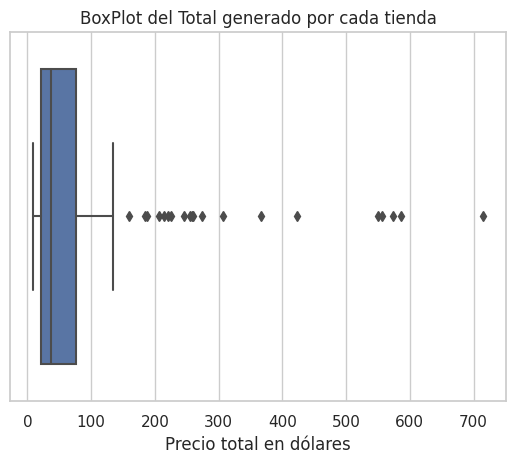

In [21]:
#Nuevo Box Plot sin la tienda
sns.boxplot(x = df_sorted2['TOTAL_PRICE'])
plt.title("BoxPlot del Total generado por cada tienda")
plt.xlabel("Precio total en dólares")
plt.show()

In [22]:
df_sorted2.describe().T

,count,mean,std,min,25%,50%,75%,max
TOTAL_PRICE,228.0,71.406184,100.917971,8.13,22.08,37.205,75.585,715.49
ORDERS,228.0,2.719298,3.513370,1.00,1.00,2.000,3.000,26.00


###Restaurantes con mayor total generado

La gráfica a continuación muestra el precio total en dolares generado por cada restaurante en nuestro top 15


In [36]:
top_15 = df_sorted2.head(15)
fig = px.bar(top_15, x='STORE_NAME', y='TOTAL_PRICE', title='Top 15 Restaurants highest Total Price',
             labels = {'STORE_NAME': 'Store Name', 'TOTAL_PRICE': 'Total Price in Dollars', 'ORDERS': 'Orders'},
             hover_data=['ORDERS'], color = 'STORE_NAME')
fig.show()

<div class="alert alert-block alert-info" style="margin-top: 20px">

**Puede observar la gráfica en el siguiente link:** [Top 15 Restaurants highest Total Price](https://rvdizeo.github.io/Door_Dash_App_Data_Analysis/top_15)

###Total de ordenes por restaurante

La gráfica a continuación muestra el número total de ordenes de cada restaurante en nuestro top 15. La barra de color en la derecha relaciona el numero de ordenes con el precio total generado por cada restaurante, donde el color amarillo representa un total muy alto y el color azul oscuro un total mas bajo.

In [38]:
fig = px.bar(top_15, x='STORE_NAME', y='ORDERS', title='Total Orders by Restaurant',
             labels = {'STORE_NAME': 'Store Name', 'ORDERS': 'Orders', 'TOTAL_PRICE': 'Total Price in Dollars'},
             hover_data=['TOTAL_PRICE'], color = 'TOTAL_PRICE')
fig.show()

<div class="alert alert-block alert-info" style="margin-top: 20px">

**Puede observar la gráfica en el siguiente link:** [Total Orders by Restaurant](https://rvdizeo.github.io/Door_Dash_App_Data_Analysis/Total_Orders_by_Restaurant.html)

<div class="alert alert-block alert-warning" style="margin-top: 20px">

**Observamos lo siguiente:**
- La tienda que mas genera dinero es Boudin SF con 715.49 dolares en 23 ordenes.
- Las tiendas Taco Bell, California Pizza Kitchen, The Cheesecake Factory y BJs Restaurant & Brewhouse generan ganancias en el rango de los 550 a 585 dolares, sin embargo Taco Bell demanda mas ordenes para lograr este objetivo, en promedio 11 ordenes mas en comparación a los otros restaurantes de este rango.
- Las tiendas McDonalds, Mezcalito Oaxacan, Chipotle, Sonic Drive-in y Crumbl Cookies generan ganancias en el rango de 220 a 260 dolares, McDonalds es la tienda que mas ordenes demanda (15 ordenes) para pertenecer a este rango, Mezcalito Oaxacan y Chipotle logran el objetivo con 7 ordenes en promedio.

###Número de ordenes en función del total generado por cada restaurante

<br>La gráfica a continuación muestra el número de ordenes en función del total generado por cada restaurante.

In [26]:
fig = px.bar(top_15, y='TOTAL_PRICE', x='ORDERS', title='Comparing Numbers of Orders with Total Price',
             labels = {'TOTAL_PRICE': 'Total Price in Dollars', 'ORDERS': 'Orders', 'STORE_NAME': 'Store Name'},
             hover_data=['STORE_NAME'], color = 'STORE_NAME')
fig.show()

<div class="alert alert-block alert-info" style="margin-top: 20px">

**Puede observar la gráfica en el siguiente link:** [Comparing Numbers of Orders with Total Price](https://rvdizeo.github.io/Door_Dash_App_Data_Analysis/Numbers_of_Orders_Total_Price.html)

<div class="alert alert-block alert-warning" style="margin-top: 20px">

**Observamos lo siguiente:**
- El total generado por las tiendas: Zocalo y DashMart combinados alcanzan los 641 dolares en 22 ordenes, Boudin-SF puede sobrepasar este monto por 75 dolares con 23 ordenes.
- California Pizza Kitchen y The Cheesecake factory pueden conseguir un total similar al generado por Taco Bell con 11 ordenes menos.
- Mendocino Farm puede generar un monto similar al de McDonalds con 5 ordenes menos.

###Análisis de restaurantes con única orden

In [27]:
df_sorted2.value_counts('ORDERS')

ORDERS
1     113
2      53
3      24
5       9
4       8
15      4
6       3
8       3
11      3
10      2
12      2
7       1
17      1
23      1
26      1
dtype: int64

<div class="alert alert-block alert-warning" style="margin-top: 20px">

**Observamos que:** el número de restaurantes que solo han tenido 1 orden es significativamente alto, por lo tanto nos dedicaremos a analizar este tema.

Extraeremos de nuestro dataset todos los restaurantes que han generado solo 1 orden y su respectivo valor, con el fin de determinar si vale la pena o no tomar la orden.

In [28]:
df_sorted3 = df_sorted2[df_sorted2["ORDERS"]==1].reset_index(drop=True)
df_sorted3.head()

#Graficamos la Orden en funcion del Precio Total
fig = px.bar(df_sorted3, y='STORE_NAME', x='TOTAL_PRICE', title='Single Order Restaurants',
             labels = {'STORE_NAME': 'Store Name', 'TOTAL_PRICE': 'Total Price in Dollars'},
             color = 'TOTAL_PRICE')
fig.show()

<div class="alert alert-block alert-info" style="margin-top: 20px">

**Puede observar la gráfica en el siguiente link:** [Single Order Restaurants](https://rvdizeo.github.io/Door_Dash_App_Data_Analysis/Single_Order_Restaurants.html)

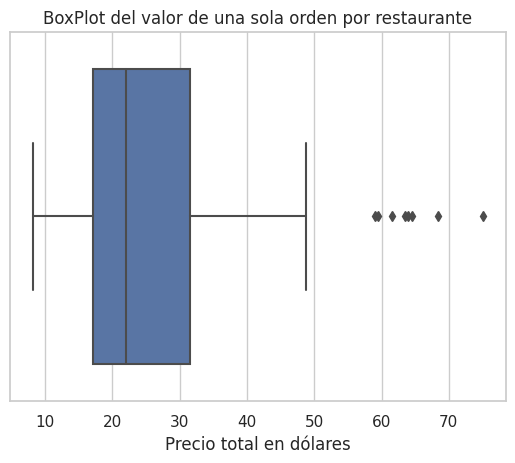

In [29]:
#Diagrama de caja para la distribucion de los restaurantes de una única orden
sns.boxplot(x = df_sorted3['TOTAL_PRICE'])
plt.title("BoxPlot del valor de una sola orden por restaurante")
plt.xlabel("Precio total en dólares")
plt.show()

In [30]:
df_sorted3.describe().T

,count,mean,std,min,25%,50%,75%,max
TOTAL_PRICE,113.0,26.54177,13.932996,8.13,17.1,22.08,31.48,75.15
ORDERS,113.0,1.00000,0.000000,1.00,1.0,1.00,1.00,1.00


<div class="alert alert-block alert-warning" style="margin-top: 20px">

**Obervamos lo siguiente:** Hay 113 restaurantes con única orden, en promedio una orden genera 26.54 dolares, sin embargo tomaremos el valor de la mediana como referencia para la toma de decisiones en el momento de recibir una orden de un nuevo restaurante ya que es un valor mas preciso debido a la distribucion de los datos.

In [31]:
#MEDIAN
df_sorted3['TOTAL_PRICE'].median()

22.08

<div class="alert alert-block alert-warning" style="margin-top: 20px">

**Resultado:** Podemos tener un buen punto de referencia para tomar una orden si esta genera un monto cercano a 22 dolares.

### Análisis del tiempo de entrega y el precio de la orden<a id="8"></a>

Centraremos el análisis en el tiempo de entrega para cada orden generada por los restaurantes de nuestro Top 15

In [32]:
lista = df_sorted['STORE_NAME'].head(16)

data_time = df[df['STORE_NAME'].isin(lista)].sort_values('STORE_NAME')
data_time = data_time[['STORE_NAME','SUBTOTAL_IN_DOLLARS','DELTA_TIME_MIN']]
data_time.head(20)

,STORE_NAME,SUBTOTAL_IN_DOLLARS,DELTA_TIME_MIN
318,BJs Restaurant & Brewhouse (Roseville - 436),30.90,39.508030
451,BJs Restaurant & Brewhouse (Roseville - 436),32.80,54.194846
634,BJs Restaurant & Brewhouse (Roseville - 436),30.55,41.286363
319,BJs Restaurant & Brewhouse (Roseville - 436),21.85,46.553067
311,BJs Restaurant & Brewhouse (Roseville - 436),38.45,51.566581
246,BJs Restaurant & Brewhouse (Roseville - 436),23.90,55.095712
442,BJs Restaurant & Brewhouse (Roseville - 436),22.90,0.324076
335,BJs Restaurant & Brewhouse (Roseville - 436),26.70,39.244163
583,BJs Restaurant & Brewhouse (Roseville - 436),62.00,2.272762
160,BJs Restaurant & Brewhouse (Roseville - 436),20.70,50.387070


Hemos obtenido un set de datos ordenados por tienda, en donde cada registro contiene el nombre de la tienda, el valor de la orden y el tiempo en completar la orden.

Nuestro objetivo es determinar el tiempo que se tarda cada orden en ser entregada, esto es: el tiempo que transcurre desde el momento en el que el usuario acepta recoger la orden hasta el momento en el que es entregada al cliente, con el fin de analizar el comportamiento de los pagos de las ordenes en función del tiempo.

#### Precio total de cada orden en función del tiempo para cada restaurante

In [33]:
data_time['SUBTOTAL_IN_DOLLARS']= data_time['SUBTOTAL_IN_DOLLARS'].astype(str)

data_time = data_time.sort_values('SUBTOTAL_IN_DOLLARS')

fig = px.line(data_time, x='SUBTOTAL_IN_DOLLARS', y='DELTA_TIME_MIN', color= 'STORE_NAME',
              labels = {'SUBTOTAL_IN_DOLLARS': 'Total Price in Dollars', 'DELTA_TIME_MIN': 'Time in minutes'},
              title='Time in minutes per order')
fig.show()

Nota: Puede pinchar en las leyendas ubicadas en la parte derecha de la gráfica, para analizar individualmente el tiempo por orden de cada restaurante.

<div class="alert alert-block alert-info" style="margin-top: 20px">

**Puede observar la gráfica en el siguiente link:** [Time in minutes per order](https://rvdizeo.github.io/Door_Dash_App_Data_Analysis/Time_in_minutes_per_order.html)

#### Relación entre el promedio del total generado por cada tienda y el promedio del tiempo empleado para entregar una orden

In [34]:
data_time[['SUBTOTAL_IN_DOLLARS']] = data_time[['SUBTOTAL_IN_DOLLARS']].astype("float")

df_price_prom = data_time.groupby(['STORE_NAME'])['SUBTOTAL_IN_DOLLARS'].agg(['median']).reset_index()

df_time_prom = data_time.groupby(['STORE_NAME'])['DELTA_TIME_MIN'].agg(['mean']).reset_index()
df_time_prom = df_time_prom.drop(['STORE_NAME'], axis=1)

df_prom = pd.concat([df_price_prom, df_time_prom], axis=1)
df_prom.columns = ['STORE_NAME', 'MEDIAN_PRICE', 'AVG_TIME']
df_prom.head(20)

,STORE_NAME,MEDIAN_PRICE,AVG_TIME
0,BJs Restaurant & Brewhouse (Roseville - 436),32.250,38.663947
1,Boudin SF (Roseville),26.600,32.491449
2,Burger Lounge (Roseville),31.890,33.212746
3,California Pizza Kitchen (293),35.150,36.179922
4,Chipotle (Creekside),34.950,37.809909
5,Crumbl Cookies (Roseville),17.100,29.653890
6,DashMart (SAC-2),21.760,25.987313
7,Jacks Urban Eats (Fountains),33.190,31.402588
8,"Lazy Dog Restaurant & Bar (Roseville, CA)",44.550,39.399310
9,McDonalds (13464-FOOTHILL & BASELINE),13.770,17.961120


In [39]:
# Create Line plot
fig = px.line(df_prom, x=df_prom['STORE_NAME'], y=df_prom['MEDIAN_PRICE'],
              labels = {'STORE_NAME': 'Store Name', 'MEDIAN_PRICE': ' '},
              title='Median Price and Average Delivery Time of each Store')

# Add Scatter plot
fig.add_scatter(name="Average Time", x=df_prom['STORE_NAME'], y=df_prom['AVG_TIME'])

# Display the plot
fig.show()

<div class="alert alert-block alert-info" style="margin-top: 20px">

**Puede observar la gráfica en el siguiente link:** [Median Price and Average Delivery Time of each Store](https://rvdizeo.github.io/Door_Dash_App_Data_Analysis/Median_Price_and_Average_Delivery_Time.html)

<div class="alert alert-block alert-warning" style="margin-top: 20px">

**Resultados:**

1. **Deberiamos evitar aceptar ordenes de:** *McDonalds, Sonic Drive-In y Taco Bell* ya que estas ordenes generan poco dinero, menos de 20 dolares, en comparación con el tiempo invertido para realizar la entrega.<br>
Aunque el promedio de pago por orden de la tienda Crumbl Cookies sea de 17 dolares, en algunos casos puede llegar a ser mayor de 40 dolares, esto se debe tener en cuenta a la hora de aceptar una orden de esta tienda.

2. **Deberiamos considedar tomar las ordenes de:** *BJs Restaurant & Brewhouse, Boudin SF, DashMart, Mendocino Farms y Zocalo*, los precios de estas tiendas oscilan en el rango de 22 a 30 dolares y el tiempo invertido al momento de realizar la entrega es de 25 a 37 min.

3. **Deberiamos aceptar ordenes de:** Burguer Lounge, California Pizza Kitchen, Chipotle, Jacks Urban Eats(Fountains) y The Cheesecake Factory ya que poseen buenos indicadores al momento de aceptar un nuevo pedido.

4. **No dudemos en aceptar una orden de:** Lazy Dog Restaurant & Bar y Mezcalito Oaxacan Cuisine ya que poseen excelentes indicadores, generando en promedio 37 a 44 dolares por orden en un tiempo de 32 a 39 min.

<br>

## Geolocalización de los restaurantes<a id="6"></a>

Descargaremos y leeremos la localización de los restaurantes contenido en otro archivo .CSV, dentro de un DataFrame para vizualizar la informacion de forma tabular.

In [ ]:
#Importing locations dataset
locations='https://docs.google.com/spreadsheets/d/e/2PACX-1vRezNPvrK5sNBzIsDBs3M15QZ-k32g_hXMzRmVI3D8Dwyx_6EclyQDW3bd_hZXnkIspVDTEUISa00Y_/pub?gid=1188365268&single=true&output=csv'
df_locations = pd.read_csv(locations)
df_locations.head(16)

,STORE_NAME,LATITUDE,LONGITUDE
0,California Pizza Kitchen at Fountains at Rosev...,38.769207,-121.268583
1,Jack's Urban Eats,38.767538,-121.268141
2,Boudin SF,38.767612,-121.269850
3,BJ's Restaurant & Brewhouse,38.768004,-121.265189
4,The Cheesecake Factory,38.772870,-121.268480
5,Burger Lounge,38.767978,-121.268146
6,Zócalo Roseville,38.768150,-121.269777
7,Lazy Dog Restaurant & Bar,38.774738,-121.274126
8,DashMart by DoorDash,38.778120,-121.263218
9,Mendocino Farms,38.767787,-121.264707


Eliminaremos el apóstrofe en algunos nombres de la coumna STORE_NAME para evitar inconvenientes en la manipulación.

In [ ]:
df_locations['STORE_NAME'] = df_locations['STORE_NAME'].str.replace("'",'')
df_locations.head()

,STORE_NAME,LATITUDE,LONGITUDE
0,California Pizza Kitchen at Fountains at Rosev...,38.769207,-121.268583
1,Jacks Urban Eats,38.767538,-121.268141
2,Boudin SF,38.767612,-121.269850
3,BJs Restaurant & Brewhouse,38.768004,-121.265189
4,The Cheesecake Factory,38.772870,-121.268480


Ubicaremos en un mapa los restaurantes del top 15 de con mayor total generado.

Agrupamos los restaurantes por ubicación y agregamos un marcador para visualizar el nombre de la tienda. <br>

<div class="alert alert-block alert-info" style="margin-top: 20px">

**Puede observar el mapa con la localización de los restaurantes en el siguiente link:** [Restaurants Location](https://rvdizeo.github.io/Door_Dash_App_Data_Analysis/map.html)

In [ ]:
from folium import plugins

# Roseville latitude and longitude values
latitude = 38.7525
longitude = -121.28944444444

# create map and display it
roseville_map = folium.Map(location=[latitude, longitude], zoom_start=12)


# instantiate a mark cluster object for the restaurants in the dataframe
restaurants = plugins.MarkerCluster().add_to(roseville_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(df_locations.LATITUDE, df_locations.LONGITUDE, df_locations.STORE_NAME):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(restaurants)

# show map
roseville_map

## Author

##### Ramiro Vasquez Di Zeo


## Change Log


|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2023-08-02  | 1.0  | Di ZeoR  |  Moved NoteBook repo in GitHub |



## <h3 align="center"> All rights reserved. <h3/>
